In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Preliminaries

Below we define a class for a skeleton. It will be initialized with the skeletal offsets as well as a kinematic tree (the different kinematic chains in the skeleton).

The base skeletal offsets characterizes the default human pose, with no rotations at any joint.

## Inverse and Forward kinematics
We denote by $R$ the rotation matrix and $T$ the translation vector associated with a bone. In particular, the translation matrix for each joint is exactly given by the skeletal offset vector. Joint locations are denoted by $j$.

The fundamental kinematic chain equation is the following:
$$\left(\begin{matrix}R_0 & T_0 \\ 0 & 1\end{matrix}\right)\cdots\left(\begin{matrix}R_{n} & T_{n} \\ 0 & 1\end{matrix}\right)\left(\begin{matrix} 0 \\ 1\end{matrix}\right) = \left(\begin{matrix} j_n \\ 1\end{matrix}\right)$$
which is equivalent to the following:
$$R_0\cdots R_{n-1} T_n = j_n - j_{n-1}$$

With the above, we are ready to implement the inverse and forward kinematics functions.

In [2]:
def RtoLie(R):
        '''Returns the axis angle aka lie algebra parameters from a rotation matrix'''
        theta = np.arccos((np.trace(R) - 1) / 2.0)
        if theta < 1e-6:
            A = np.zeros(3)
        else:
            A = theta / (2 * np.sin(theta)) * np.array([R[2, 1] - R[1, 2], R[0, 2] - R[2, 0], R[1, 0] - R[0, 1]])
        return A

def LietoR(A):
    '''Returns the rotation matrix from lie algebra parameters'''
    theta = np.linalg.norm(A)
    if theta == 0:
        R = np.identity(3)
    else:
        A = A / theta
        cross_matrix = np.array([[0, -A[2], A[1]], [A[2], 0, -A[0]], [-A[1], A[0], 0]])
        R = np.identity(3) + np.sin(theta) * cross_matrix + (1 - np.cos(theta)) * np.matmul(cross_matrix, cross_matrix)
    return R

def findrot(u, v):
    '''find the axis angle parameters to rotate unit vector u onto unit vector v'''
    w = np.cross(u, v)
    w_norm = np.linalg.norm(w)
    if w_norm < 1e-6:
        A = np.zeros(3)
    else:
        A = w / w_norm * np.arccos(np.dot(u, v))
    return A

class Skeleton:
    def __init__(self, raw_offsets, kinematic_tree):
        self._raw_offsets = raw_offsets
        self._kinematic_tree = kinematic_tree
        self._offsets = None
        self._parents = [0] * len(self._raw_offsets)
        self._parents[0] = -1
        for chain in self._kinematic_tree:
            for j in range(1, len(chain)):
                self._parents[chain[j]] = chain[j-1]
                
    def njoints(self):
        return len(self._raw_offsets)
    
    def raw_offsets(self):
        return self._raw_offsets
    
    def kinematic_tree(self):
        return self._kinematic_tree
    
    def parents(self):
        return self._parents

    def offsets(self):
        return self._offsets
    
    def get_bonelengths(self, joints):
        self._offsets = np.double(np.array(self._raw_offsets))
        for i in range(1, len(self._raw_offsets)):
            self._offsets[i] = np.linalg.norm(joints[i] - joints[self._parents[i]]) * self._offsets[i]
    
    def inverse_kinematics(self, joints):
        lie_params = np.zeros([len(self._raw_offsets),3])
        for chain in self._kinematic_tree:
            R = np.eye(3)
            for j in range(len(chain)-1):
                u = self._raw_offsets[chain[j+1]]
                v = joints[chain[j+1]]-joints[chain[j]]
                v = v / np.linalg.norm(v)
                R_local = np.matmul(np.transpose(R), LietoR(findrot(u,v)))
                lie_params[chain[j+1]] = RtoLie(R_local)
                R = np.matmul(R, R_local)
        return lie_params
    
    def forward_kinematics(self, lie_params):
        if self._offsets is None:
            raise Exception('Get bone lengths first')
        joints = np.zeros([len(self._raw_offsets), 3])
        for chain in self._kinematic_tree:
            R = np.eye(3)
            for i in range(1, len(chain)):
                R = np.matmul(R, LietoR(lie_params[chain[i]]))
                joints[chain[i]] = np.matmul(R, self._offsets[chain[i]]) + joints[chain[i-1]]
        return joints
    
    def plot(self, joints):
        plt.figure()
        ax = plt.axes(xlim=(-1,1), ylim=(-1,1), zlim=(-1,1), projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(elev=110, azim=-90)
        ax.scatter(joints[:,0], joints[:,1], joints[:,2], color='black')
        colors = ['red', 'yellow', 'black', 'green', 'blue']
        for chain, color in zip(self._kinematic_tree, colors):
            ax.plot3D(joints[chain,0], joints[chain,1], joints[chain,2], linewidth=2.0, color=color)


## Initialze Skeleton class with following parameters

In [3]:
# Skeleton offsets without bonelength information
raw_offsets = [[0,0,0],
               [1,0,0],
               [-1,0,0],
               [0,1,0],
               [0,-1,0],
               [0,-1,0],
               [0,1,0],
               [0,-1,0],
               [0,-1,0],
               [0,1,0],
               [0,0,1],
               [0,0,1],
               [0,1,0],
               [1,0,0],
               [-1,0,0],
               [0,0,1],
               [0,-1,0],
               [0,-1,0],
               [0,-1,0],
               [0,-1,0],
               [0,-1,0],
               [0,-1,0],
               [0,-1,0],
               [0,-1,0]]

# Define a kinematic tree for the skeletal struture
kinematic_tree = [[0,1,4,7,10], [0,2,5,8,11], [0,3,6,9,12,15], [9,13,16,18,20,22], [9,14,17,19,21,23]]

human_skel = Skeleton(raw_offsets, kinematic_tree)

In [4]:
def load_joints(file):
    joints = np.load(file)
    njoints = joints.shape[0]
    joints = joints - np.tile(joints[0],[njoints, 1])
    joints = -joints
    return joints

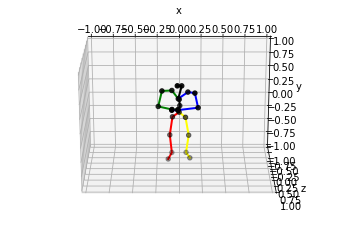

In [5]:
joints = load_joints('P00G01R01C02F0000_3d.npy')
human_skel.plot(joints)

In [6]:
human_skel.get_bonelengths(joints)

In [7]:
lie_params = human_skel.inverse_kinematics(joints)

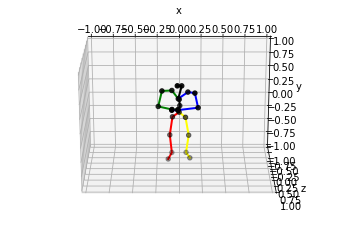

In [8]:
newjoints= human_skel.forward_kinematics(lie_params)
human_skel.plot(newjoints)